In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

plt.style.use('default')

In [2]:
data = pd.read_csv("electric_consumption_till_25jun.csv").drop(columns=["Unnamed: 0"])
data.Date = pd.to_datetime(data.Date)
data['day_name'] = data.Date.dt.day_name()
data['month_name'] = data.Date.dt.month_name()
data['hour'] = data.Date.dt.hour
data['day'] = data.Date.dt.day
data['month'] = data.Date.dt.month
data['year'] = data.Date.dt.year
data['hour'] = [f"{i}" for i in data.Date.dt.hour.astype('str')]

for days in range(1, 30):
    hours_shift = 24 * days
    data[f'{days}_day_shift'] = np.concatenate([np.array([np.nan] * hours_shift), data.Consumption.to_numpy()[:-hours_shift]])

data = pd.get_dummies(data)
data = data.fillna(data.Consumption[0])

# Drop Highly Correlated Features
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     corr_matrix = data.corr().abs()
#     upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
#     to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
#     data.drop(to_drop, axis=1, inplace=True)

data.head(3)

,Date,Homestead_maxtempC,Homestead_mintempC,Homestead_DewPointC,Homestead_FeelsLikeC,Homestead_HeatIndexC,Homestead_WindChillC,Homestead_WindGustKmph,Homestead_cloudcover,Homestead_humidity,...,hour_21,hour_22,hour_23,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9
0,2020-06-25 17:00:00,33.0,27.0,23.0,36.0,36.0,31.0,24.0,9.0,62.0,...,0,0,0,0,0,0,0,0,0,0
1,2020-06-25 16:00:00,33.0,27.0,23.0,37.0,37.0,32.0,24.0,7.0,60.0,...,0,0,0,0,0,0,0,0,0,0
2,2020-06-25 15:00:00,33.0,27.0,23.0,38.0,38.0,33.0,23.0,5.0,57.0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_data = data.drop(columns=["Consumption", "Date"]).to_numpy()
y_data = data["Consumption"].to_numpy()

X_data = scaler.fit_transform(X_data)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, shuffle=False)

X_data.shape, y_data.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((22201, 90), (22201,), (15540, 90), (15540,), (6661, 90), (6661,))

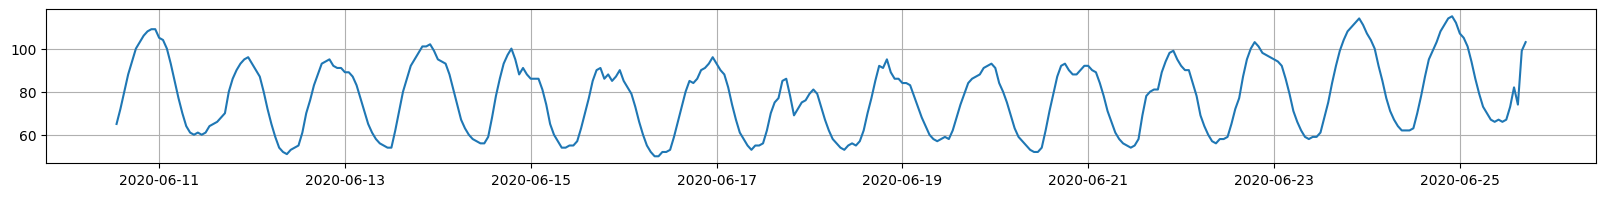

In [4]:
plt.figure(figsize=(20, 2))
plt.plot(data.Date[:365], y_data[:365])
plt.grid()

In [5]:
X_DIMENSIONS = X_data.shape[1]
X_DIMENSIONS

90

In [6]:
from sklearn.metrics import mean_absolute_percentage_error

In [7]:
# import tensorflow as tf
# import numpy as np
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, shuffle=False)

# def modified_adaptive_wavelet(X, alpha, sigma, ro, c):
#     return (1 - alpha * ((X - c) / sigma) * tf.square(ro) * tf.exp(-tf.square(ro)/2))

# def wavelet_sublayer(num_wavelets, W, X, alpha, sigma, ro, c):
#     return tf.reduce_sum([W[:, i] * modified_adaptive_wavelet(X, alpha[:, i], c[:, i], sigma[:, i], ro[:, i]) for i in range(num_wavelets)], axis=0)

# def wavelet_neuron(X, W, alpha, sigma, ro, c, num_wavelets=3):
#     return tf.reduce_sum(wavelet_sublayer(X=X, W=W, alpha=alpha, sigma=sigma, ro=ro, c=c, num_wavelets=num_wavelets), axis=1)

# num_wavelets = 5

# # Initialize weights and biases
# W = tf.Variable(tf.random.normal((X_DIMENSIONS, num_wavelets)), name="W")
# c = tf.Variable(tf.random.normal((X_DIMENSIONS, num_wavelets)), name="c")

# alpha = tf.Variable(tf.random.normal((X_DIMENSIONS, num_wavelets)), name="alpha")
# sigma = tf.Variable(tf.random.normal((X_DIMENSIONS, num_wavelets)), name="sigma")
# ro = tf.Variable(tf.random.normal((X_DIMENSIONS, num_wavelets)), name="ro")

# # Training loop
# epochs = 50000
# learning_rate = 0.001
# optimizer = tf.optimizers.Adam(learning_rate)

# training_losses = []
# validation_losses = []
# training_MAPE = []
# validation_MAPE = []

# for epoch in range(epochs):
#     with tf.GradientTape() as tape:
#         training_output = wavelet_neuron(X_train, W, alpha, sigma, ro, c, num_wavelets=num_wavelets)
#         training_loss = tf.reduce_mean(tf.square(training_output - y_train))
#         training_losses.append(training_loss)
    
#     validation_output = wavelet_neuron(X_test, W, alpha, sigma, ro, c, num_wavelets=num_wavelets)
#     validation_loss = tf.reduce_mean(tf.square(validation_output - y_test))
#     validation_losses.append(validation_loss)
    
#     gradients = tape.gradient(training_loss, [W, alpha, sigma, ro, c])
#     optimizer.apply_gradients(zip(gradients, [W, alpha, sigma, ro, c]))
    
#     training_metric = mean_absolute_percentage_error(y_train, training_output)
#     validation_metric = mean_absolute_percentage_error(y_test, validation_output)
#     training_MAPE.append(training_metric)
#     validation_MAPE.append(validation_metric)
    
#     if (epoch + 1) % 100 == 0:
#         print(f"Epoch {epoch + 1}/{epochs}  "
#               f"\t MSE: {training_loss:.4f}"
#               f"\t MAPE: {100 * training_metric:.2f}%"
#               f"\t Validation MSE: {validation_loss:.4f}" 
#               f"\t Validation MAPE: {100 * validation_metric:.2f}%")

# # Calculate the final neuron output
# final_output = wavelet_neuron(X_train, W, alpha, sigma, ro, c, num_wavelets=num_wavelets)

In [8]:
from tensorflow.keras.layers import Layer

class SingleAdaptiveWavelet(Layer):
    def __init__(self, alpha_lower=0, alpha_upper=1, sigma_lower=-100, sigma_upper=100, c_lower=-100, c_upper=100, eps=0.001, initialize='random', **kwargs):
        super(SingleAdaptiveWavelet, self).__init__(**kwargs)
        self.alpha_lower = alpha_lower + eps
        self.alpha_upper = alpha_upper - eps
        self.sigma_lower = sigma_lower + eps
        self.sigma_upper = sigma_upper - eps
        self.c_lower = c_lower + eps
        self.c_upper = c_upper - eps
        self.eps = eps
        self.initialize = initialize

    def build(self, input_shape):
        # Create the layer's weights and biases
        if self.initialize == 'random':
            alpha_init = 'random_normal'
            sigma_init = 'random_normal'
            c_init = 'random_normal'
        elif self.initialize == 'lower':
            alpha_init = tf.constant_initializer(self.alpha_lower)
            sigma_init = tf.constant_initializer(self.sigma_lower)
            c_init = tf.constant_initializer(self.c_lower)
        elif self.initialize == 'upper':
            alpha_init = tf.constant_initializer(self.alpha_upper)
            sigma_init = tf.constant_initializer(self.sigma_upper)
            c_init = tf.constant_initializer(self.c_upper)
        else:
            raise ValueError("initialize must be random, lower, or upper")
            
        
        
        self.W = self.add_weight(name="W", shape=(input_shape[-1],), initializer="random_normal", trainable=True)
        
        self.alpha = self.add_weight(name="alpha", shape=(input_shape[-1],), 
                                     initializer=alpha_init, trainable=True, 
                                     constraint=lambda z: tf.clip_by_value(z, self.alpha_lower, self.alpha_upper))
        self.sigma = self.add_weight(name="sigma", shape=(input_shape[-1],), 
                                     initializer=sigma_init, trainable=True, 
                                     constraint=lambda z: tf.clip_by_value(z, self.sigma_lower, self.sigma_upper))
        self.c = self.add_weight(name="c", shape=(input_shape[-1],), 
                                 initializer=c_init, trainable=True,
                                 constraint=lambda z: tf.clip_by_value(z, self.c_lower, self.c_upper))
        
        super(SingleAdaptiveWavelet, self).build(input_shape)

    def call(self, inputs):
        return self.wavelet_neuron(inputs)

    def wavelet_neuron(self, X):
        
        def modified_adaptive_wavelet(X, alpha, sigma, c):
            return (1 - alpha * tf.square(ro(X, sigma, c)) * tf.exp(-tf.square(ro(X, sigma, c)) / 2))
        
        def ro(X, sigma, c):
            return ((X - c) / sigma)
        
        return self.W * modified_adaptive_wavelet(X, self.alpha, self.sigma, self.c)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])
    
    

class WFNT1(Layer):
    def __init__(self, num_wavelets, alpha_lower=0, alpha_upper=1, sigma_lower=-100, sigma_upper=100, c_lower=-100, c_upper=100, eps=0.001, initialize='random', **kwargs):
        super(WFNT1, self).__init__(**kwargs)
        self.num_wavelets = num_wavelets
        self.alpha_lower = alpha_lower + eps
        self.alpha_upper = alpha_upper - eps
        self.sigma_lower = sigma_lower + eps
        self.sigma_upper = sigma_upper - eps
        self.c_lower = c_lower + eps
        self.c_upper = c_upper - eps
        self.eps = eps
        self.initialize = initialize

    def build(self, input_shape):
        self.wavelets = [SingleAdaptiveWavelet(alpha_lower=self.alpha_lower, 
                                               alpha_upper=self.alpha_upper, 
                                               sigma_lower=self.sigma_lower,
                                               sigma_upper=self.sigma_upper, 
                                               c_lower=self.c_lower, 
                                               c_upper=self.c_upper, 
                                               eps=0.001, initialize='random') for _ in range(self.num_wavelets)]
        super(WFNT1, self).build(input_shape)

    def call(self, inputs):
        return self.wavelet_neuron(inputs)

    def wavelet_neuron(self, X):

        def wavelet_sublayer(X):
            return tf.reduce_sum([wavelet(X) for wavelet in self.wavelets], axis=0)

        return tf.reduce_sum(wavelet_sublayer(X), axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])
    
    
    
class WFNT2(Layer):
    def __init__(self, num_wavelets, alpha_lower=-100, alpha_upper=100, sigma_lower=0, sigma_upper=100, c_lower=-100, c_upper=100, eps=0.001, **kwargs):
        super(WFNT2, self).__init__(**kwargs)
        self.num_wavelets = num_wavelets
        self.alpha_upper = alpha_upper
        self.sigma_upper = sigma_upper
        self.c_upper = c_upper
        self.alpha_lower = alpha_lower
        self.sigma_lower = sigma_lower
        self.c_lower = c_lower
        self.eps = eps

    def build(self, input_shape):
        self.upper_WFNT1 =  WFNT1(self.num_wavelets, self.alpha_lower, self.alpha_upper, self.sigma_lower, self.sigma_upper, self.c_lower, self.c_upper, initialize='upper')
        self.lower_WFNT1 =  WFNT1(self.num_wavelets, self.alpha_lower, self.alpha_upper, self.sigma_lower, self.sigma_upper, self.c_lower, self.c_upper, initialize='lower')
        self.c = self.add_weight(name="c_separator", shape=(1, ), initializer="random_normal", trainable=True, constraint=lambda z: tf.clip_by_value(z, 0, 1))
        super(WFNT2, self).build(input_shape)

    def call(self, inputs):
        return self.wavelet_neuron(inputs)

    def wavelet_neuron(self, X):
        y_upper = self.upper_WFNT1(X)
        y_lower = self.lower_WFNT1(X)
        return self.c * y_upper + (1 - self.c) * y_lower

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])

In [9]:
def r_squared(y, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model


def create_wfn_type_1_model(input_dimensions, num_wavelets=5):
    input_layer = Input(shape=(input_dimensions,))
    adaptive_wavelet_layer = WFNT1(num_wavelets)(input_layer)
    model = Model(inputs=input_layer, outputs=adaptive_wavelet_layer)
    return model
    
def create_wfn_type_2_model(input_dimensions, num_wavelets=5):
    input_layer = Input(shape=(input_dimensions,))
    adaptive_wavelet_layer = WFNT2(num_wavelets)(input_layer)
    model = Model(inputs=input_layer, outputs=adaptive_wavelet_layer)
    return model

# Creating models
wfnt1_model = create_wfn_type_1_model(input_dimensions=X_DIMENSIONS, num_wavelets=5)
wfnt2_model = create_wfn_type_2_model(input_dimensions=X_DIMENSIONS, num_wavelets=5)

# Compiling models
wfnt1_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mape', r_squared])
wfnt2_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mape', r_squared])

# Training models
print("Training WFNT1")
wfnt1_history = wfnt1_model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), verbose=1)
print("Training WFNT2")
wfnt2_history = wfnt2_model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), verbose=1)

Training WFNT1
Epoch 1/200
486/486 [==============================] - 11s 19ms/step - loss: 825.1163 - mape: 33.6004 - r_squared: -1.5360 - val_loss: 319.9128 - val_mape: 27.2329 - val_r_squared: -1.5372
Epoch 2/200
486/486 [==============================] - 9s 18ms/step - loss: 331.3340 - mape: 25.5464 - r_squared: -0.0254 - val_loss: 309.7042 - val_mape: 26.4319 - val_r_squared: -1.4041
Epoch 3/200
486/486 [==============================] - 9s 18ms/step - loss: 309.4874 - mape: 24.6533 - r_squared: 0.0414 - val_loss: 280.6413 - val_mape: 25.0946 - val_r_squared: -1.2018
Epoch 4/200
486/486 [==============================] - 9s 18ms/step - loss: 272.9697 - mape: 23.0644 - r_squared: 0.1530 - val_loss: 252.7256 - val_mape: 23.7927 - val_r_squared: -1.0253
Epoch 5/200
486/486 [==============================] - 9s 18ms/step - loss: 239.4267 - mape: 21.4958 - r_squared: 0.2582 - val_loss: 225.4723 - val_mape: 22.3962 - val_r_squared: -0.8386
Epoch 6/200
486/486 [==========================

## WFN Type 1 Results

In [18]:
wfnt1_y_pred_test = wfnt1_model.predict(X_test)
loss, mape, mae = wfnt1_model.evaluate(X_test, y_test)
print(f"MODEL WFNT1 RESULTS:\nTest Loss: {loss:.4f}, Test MAPE: {mape:.4f}, Test R-squred: {mae:.4f}")

209/209 [==============================] - 1s 6ms/step - loss: 52.3221 - mape: 9.0252 - r_squared: 0.6205
MODEL WFNT1 RESULTS:
Test Loss: 52.3221, Test MAPE: 9.0252, Test R-squred: 0.6205


(0.0, 200.0)

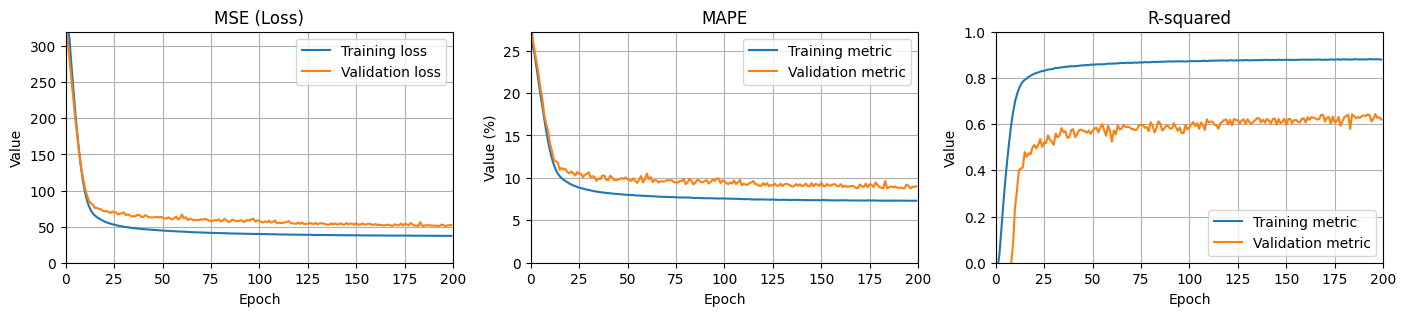

In [12]:
training_mse = wfnt1_history.history['loss']
validation_mse = wfnt1_history.history['val_loss'] 
training_mape = wfnt1_history.history['mape']
validation_mape = wfnt1_history.history['val_mape'] 
training_mae = wfnt1_history.history['r_squared']
validation_mae = wfnt1_history.history['val_r_squared'] 


plt.figure(figsize=(17, 3))

plt.subplot(1, 3, 1)
plt.plot(training_mse, label="Training loss")
plt.plot(validation_mse, label="Validation loss")
plt.ylim([0, validation_mse[0]])
plt.title("MSE (Loss)")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.grid()
plt.xlim(0, len(validation_mse))

plt.subplot(1, 3, 2)
plt.plot(training_mape, label="Training metric")
plt.plot(validation_mape, label="Validation metric")
plt.ylim([0, validation_mape[0]])
plt.title("MAPE")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value (%)')
plt.grid()
plt.xlim(0, len(validation_mape))

plt.subplot(1, 3, 3)
plt.plot(training_mae, label="Training metric")
plt.plot(validation_mae, label="Validation metric")
plt.ylim([0, 1])
plt.title("R-squared")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.grid()
plt.xlim(0, len(validation_mae))

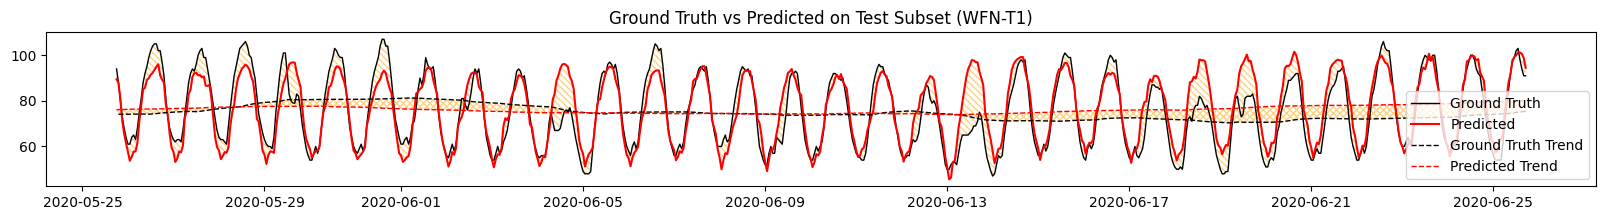

In [13]:
window = (24*0, 24*31)
maw = 24*7

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

x_plot = data.Date[window[0]:window[1]]
y_test_plot = y_test[window[0]:window[1]]
y_pred_plot = wfnt1_y_pred_test[window[0]:window[1]]
y_test_plot_ma = moving_average(y_test[window[0]:window[1]+maw-1], w=maw)
y_pred_plot_ma = moving_average(wfnt1_y_pred_test[window[0]:window[1]+maw-1], w=maw)

plt.figure(figsize=(20, 2))
plt.plot(x_plot, y_test_plot, c="black", linewidth='1', label='Ground Truth')
plt.plot(x_plot, y_pred_plot,  c='red', label='Predicted')
plt.fill_between(x_plot, y_test_plot, y_pred_plot, alpha=0.5, facecolor="none", hatch="\\\\\\\\\\", edgecolor="orange", linewidth=0.0)
plt.title("Ground Truth vs Predicted on Test Subset (WFN-T1)")
plt.plot(x_plot, y_test_plot_ma, c="black", linewidth='1', linestyle="dashed", label='Ground Truth Trend')
plt.plot(x_plot, y_pred_plot_ma, c='red', linewidth='1', linestyle="dashed", label='Predicted Trend')
plt.fill_between(x_plot, y_test_plot_ma, y_pred_plot_ma, alpha=0.5, facecolor="none", hatch="XXXXX", edgecolor="orange", linewidth=0.0)

plt.legend()

## WFN Type 2 Results

In [19]:
wfnt2_y_pred_test = wfnt2_model.predict(X_test)
loss, mape, mae = wfnt2_model.evaluate(X_test, y_test)
print(f"MODEL WFNT2 RESULTS:\nTest Loss: {loss:.4f}, Test MAPE: {mape:.4f}, Test R-squred: {mae:.4f}")

209/209 [==============================] - 2s 10ms/step - loss: 41.6250 - mape: 7.6134 - r_squared: 0.7228
MODEL WFNT2 RESULTS:
Test Loss: 41.6250, Test MAPE: 7.6134, Test R-squred: 0.7228


In [15]:
wfnt2_model.weights[0]

<tf.Variable 'wfnt2/c_separator:0' shape=(1,) dtype=float32, numpy=array([0.32224935], dtype=float32)>

(0.0, 200.0)

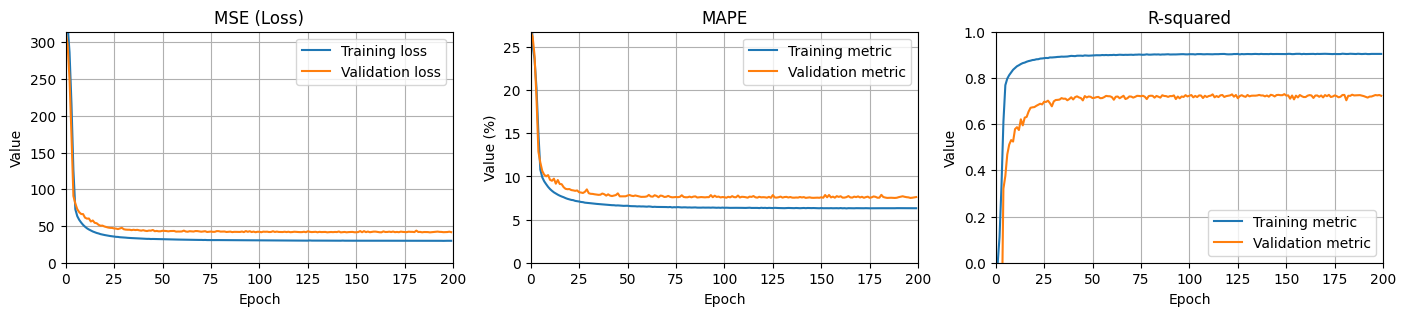

In [16]:
training_mse = wfnt2_history.history['loss']
validation_mse = wfnt2_history.history['val_loss'] 
training_mape = wfnt2_history.history['mape']
validation_mape = wfnt2_history.history['val_mape'] 
training_mae = wfnt2_history.history['r_squared']
validation_mae = wfnt2_history.history['val_r_squared'] 

plt.figure(figsize=(17, 3))

plt.subplot(1, 3, 1)
plt.plot(training_mse, label="Training loss")
plt.plot(validation_mse, label="Validation loss")
plt.ylim([0, validation_mse[0]])
plt.title("MSE (Loss)")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.grid()
plt.xlim(0, len(validation_mse))

plt.subplot(1, 3, 2)
plt.plot(training_mape, label="Training metric")
plt.plot(validation_mape, label="Validation metric")
plt.ylim([0, validation_mape[0]])
plt.title("MAPE")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value (%)')
plt.grid()
plt.xlim(0, len(validation_mape))

plt.subplot(1, 3, 3)
plt.plot(training_mae, label="Training metric")
plt.plot(validation_mae, label="Validation metric")
plt.ylim([0, 1])
plt.title("R-squared")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.grid()
plt.xlim(0, len(validation_mae))

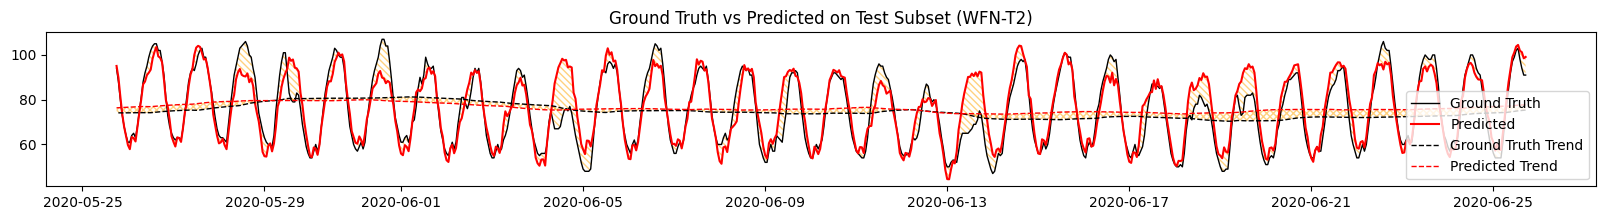

In [17]:
window = (24*0, 24*31)
maw = 24*7

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

x_plot = data.Date[window[0]:window[1]]
y_test_plot = y_test[window[0]:window[1]]
y_pred_plot = wfnt2_y_pred_test[window[0]:window[1]]
y_test_plot_ma = moving_average(y_test[window[0]:window[1]+maw-1], w=maw)
y_pred_plot_ma = moving_average(wfnt2_y_pred_test[window[0]:window[1]+maw-1], w=maw)

plt.figure(figsize=(20, 2))
plt.plot(x_plot, y_test_plot, c="black", linewidth='1', label='Ground Truth')
plt.plot(x_plot, y_pred_plot,  c='red', label='Predicted')
plt.fill_between(x_plot, y_test_plot, y_pred_plot, alpha=0.5, facecolor="none", hatch="\\\\\\\\\\", edgecolor="orange", linewidth=0.0)
plt.title("Ground Truth vs Predicted on Test Subset (WFN-T2)")
plt.plot(x_plot, y_test_plot_ma, c="black", linewidth='1', linestyle="dashed", label='Ground Truth Trend')
plt.plot(x_plot, y_pred_plot_ma, c='red', linewidth='1', linestyle="dashed", label='Predicted Trend')
plt.fill_between(x_plot, y_test_plot_ma, y_pred_plot_ma, alpha=0.5, facecolor="none", hatch="XXXXX", edgecolor="orange", linewidth=0.0)

plt.legend()